<h1> The SVD Ellipsoid <span class="tocSkip"></span></h1>

* This Jupyter notebook accompanies the **Linear Algebra** course in the [ICME Summer Workshops in Data Science](https://icme.stanford.edu/icme-summer-workshops-2021-fundamentals-data-science#LinAlg) (2021) series. 
* This course is taught by Professor Margot Gerritsen and Laura Lyman.

*Note. Any time a matrix $A$ is specified as $m \times n$ matrix, we assume that $m \ge n$. This has no loss of generality, because if $m \le n$, then we simply would analyze $A^T$ instead. As before, we assume that all matrices and vectors are real-valued.*

1. In this module, we explore how any matrix $2 \times 2$ matrix $A$ transforms a unit circle into an ellipse. With the SVD, we can show that the lengths of the semi-axes of the ellipse are given by the singular values $\sigma_1$ and $\sigma_2$ of $A$

2. We will observe the same notion in $3$-dimensions; namely, any $3 \times 3$ matrix $A$ transforms the sphere into an *ellipsoid*. The magnitude of the ellipsoid's semi-axes are precisely the singular valuse $\sigma_1, \sigma_2, \sigma_3$ of $A$.

3. For a general $m \times n$ matrix, left multiplication by $A$ maps the $n$-sphere to an $n$-dimensional ellipsoid embedded in $m$ space. As before, the singular values of $A$ give the lengths of the $n$ total semi-axes of the $n$-dimensional ellipse inside $m$ space.

  For instance, if $A$ is $3 \times 2$, then $A$ sends the unit circle to an ellipse on a 2 dimensional plane in 3 space. In this case, $\Sigma$ is an $3 \times 2$ matrix with singular values $\sigma_1, \sigma_2$. The semi-axes of the flat ellipse inside 3 space have lengths 3 and 2. 

4. Time permitting, we can also observe that when $A$ is symmetric, the directions of the semi-axes are specified by the eigenvectors of $A$, which are guaranteed to be orthogonal. 

All of these principals can be seen through the SVD.


In [1]:
import math
from   matplotlib.animation import FuncAnimation
from   matplotlib.patches import Ellipse
from   mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from   matplotlib.widgets import Slider, Button
import numpy as np

icme_gold = '#fcc329'

Recall that for *any* real $m \times n$ matrix $A$, the SVD gives the matrix factorization

$$ A = U \Sigma V^T$$
where
* $U$ is $m \times m$ orthogonal (so $U^T U = U U^T = I_{m \times m}$
* $\Sigma$ is $m \times n$ of the form $\Sigma = \begin{pmatrix} \sigma_1 & & \\ & \ddots & \\ & & \sigma_n \\ 0 & \cdots & 0 \\ \vdots & & \vdots \\ 0 & \cdots & 0 \end{pmatrix}_{m \times n}$
* $V$ is $n \times n$ orthogonal (so $V^T V = V V^T = I_{n \times n}$

For the first example, consider the $2 \times 2$ matrix $A$,
$$ A =  \begin{pmatrix} \hphantom{-} \frac{\sqrt 3}{2} & \frac{1}{2} \\ - \frac{1}{2} & \frac{\sqrt 3}{2} \end{pmatrix}\begin{pmatrix} \vphantom{\frac{\sqrt 3}{2}} 3 & 0 \\ \vphantom{\frac{\sqrt 3}{2}} 0 & 2 \end{pmatrix}\begin{pmatrix} \hphantom{-}\frac{1}{\sqrt 2} & \frac{1}{\sqrt 2} \\ - \frac{1}{\sqrt 2} & \frac{1}{\sqrt 2} \end{pmatrix}  $$the 


[Wikipedia](https://upload.wikimedia.org/wikipedia/commons/b/bb/Singular-Value-Decomposition.svg) has the following useful graphic for demonstrating these transformations! 

<img alttext = "SVD Ellipsoid" src = "https://upload.wikimedia.org/wikipedia/commons/b/bb/Singular-Value-Decomposition.svg" width = "50%" height = "50%"></img>

*(**Note.** The $V^*$ in this image denotes the conjugate transpose of $V$, which is a generalization of the transpose; however, since we are assuming all real-valued matrices, we can replace this $V^*$ with $V^T$.)*

Of course, we should understand *why* this is true for ourselves. To do so, we explain the mathematics theoretically and *also* test this out directly on some data points.  


In [3]:
def removehalflabels(num_removals, remove_xlabs=True, remove_ylabs=True, start = 0):
    # Get the current locations and labels
    labels_x = plt.xticks()[1]
    labels_y = plt.yticks()[1]
    for i in range(num_removals):
        if remove_xlabs: labels_x[2*i + start].set_visible(False)
        if remove_ylabs: labels_y[2*i + start].set_visible(False)
    
def plot_vecs(vec_list, vec_colors, alpha = 1):
    axiscolor = '#A9A9A9'
    plt.figure()
    plt.axvline(x=0, color=axiscolor, zorder=0)
    plt.axhline(y=0, color=axiscolor, zorder=0)
    
    for i in range(len(vec_list)):
        x = np.concatenate([[0,0], vec_list[i]])
        plt.quiver([x[0]],[x[1]],[x[2]],[x[3]],
                   angles='xy', scale_units='xy', 
                   scale=1, color=vec_colors[i],
                   alpha=alpha)

def pts_on_unit_circ():
    x = np.linspace(-1, 1, 100000)
    y = np.sqrt(1-(x**2))
    circ_pts_top = np.vstack((x,y))
    circ_pts_bottom = np.vstack((x,-y))
    return(circ_pts_top, circ_pts_bottom)

# Left multiply a shape by a 2 x 2 inputted matrix A and plot it
#
# If no shape specified, defaults to transforming the unit circle
# Assumes the "shape" is a tuple of matrices of size 2 x N, where shape[0] gives the N points
# above the x-axis, and shape[1] gives the N points below the x-axis
# Also plots the effect of left multiplying reference vectors (shown as axes in the plot) by A 
# By default, the reference vectors u and v, the columns of the `ref_vecs` variable,
# are e1 = [1,0] and e2 = [0,1]
def apply_A_to_circle(A, ref_vecs = np.eye(2), basis_colors=['deeppink', icme_gold], shape=None):
    
    # Function call didn't specify what shape A is operating on, so default
    # to the unit circle
    if shape is None: shape_pts_top, shape_pts_bottom = pts_on_unit_circ()
    else:
        shape_pts_top    = shape[0]
        shape_pts_bottom = shape[1]
    # Apply A to the unit circle (or some inputted shape)
    A_times_shape_top    = np.matmul(A, shape_pts_top)
    A_times_shape_bottom = np.matmul(A, shape_pts_bottom)
    x1     = A_times_shape_top[0, :]
    y1     = A_times_shape_top[1, :]
    x1_neg = A_times_shape_bottom[0, :]
    y1_neg = A_times_shape_bottom[1,:]

    # Transform reference vectors
    A_times_vecs    = np.matmul(A, ref_vecs)
    A_times_u       = A_times_vecs[:,0]
    A_times_v       = A_times_vecs[:,1]

    plot_vecs([A_times_u, A_times_v], vec_colors = [basis_colors[0], basis_colors[1]])
    plt.plot(x1, y1, 'mediumslateblue')
    plt.plot(x1_neg, y1_neg, 'mediumslateblue')
    plt.grid(True, linestyle='dashed', alpha=0.5)
    
    A_times_shape = tuple((A_times_shape_top, A_times_shape_bottom))
    # Return the transformed shape and reference vectors; we might not use these returned
    # variables if we only call this method to plot, but we have it just in case
    return(A_times_vecs, A_times_shape)
    

In [4]:
A                   = np.array([[3, 7], [5, 2]])
[U, sing_vals, V_t] = np.linalg.svd(A)
Sigma = np.diag(sing_vals)
print(Sigma)

# Verify that we recover A from this decomposition
print(np.matmul(U, np.matmul(Sigma, V_t)))

[[8.71337969 0.        ]
 [0.         3.32821489]]
[[3. 7.]
 [5. 2.]]


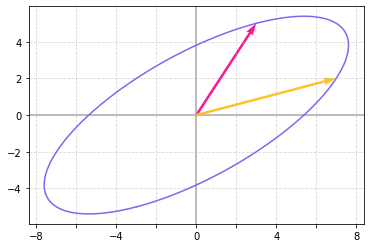

In [10]:
apply_A_to_circle(A)
removehalflabels(5, remove_ylabs=False)

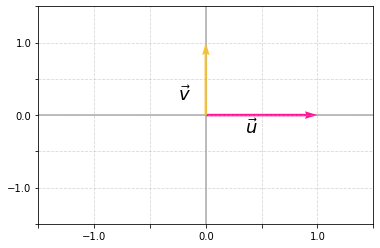

In [6]:
u = [1, 0]
v = [0, 1]

plot_vecs([u, v], ["deeppink", icme_gold])

removehalflabels(4)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.text(-0.25, 0.2, r'$\vec{v}$',  color="black", size=18)
plt.text(0.35, -0.25, r'$\vec{u}$', color="black", size=18)
plt.grid(True, linestyle="dashed",  alpha=0.5)

plt.show()

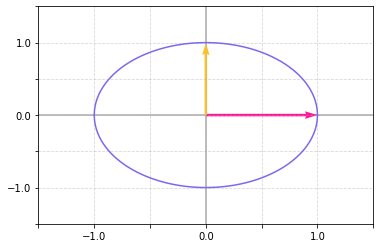

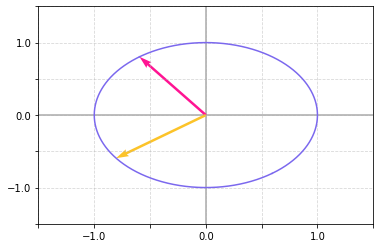

In [7]:
# Show original unit circle ("transform" by identity matrix)
apply_A_to_circle(np.eye(2,2))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
removehalflabels(4)
plt.show()

# Show how V^t operates on unit circle (it's a rotation or reflection)
V_t_applied_to_u_v, V_t_times_circ = apply_A_to_circle(V_t)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
removehalflabels(4)
plt.show()

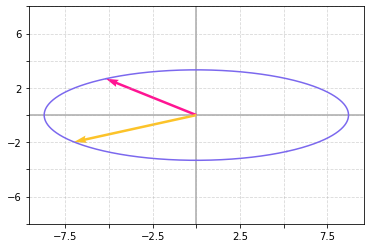

In [8]:
# Show how entries of Sigma scale then scale the rotated unit circle axes
# and transform the circle to an ellipse
Sigma_V_t_applied_to_u_v, Sig_V_t_times_circ = apply_A_to_circle(Sigma, ref_vecs=V_t_applied_to_u_v, \
                                                                 shape=V_t_times_circ)
plt.ylim(-8, 8)
removehalflabels(4)
plt.yticks()[1][-1].set_visible(False)
plt.show()

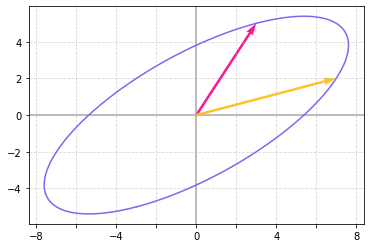

In [9]:
# Show how U then rotates/reflects the ellipse
apply_A_to_circle(U, ref_vecs=Sigma_V_t_applied_to_u_v, shape=Sig_V_t_times_circ)
removehalflabels(5, remove_ylabs=False)
plt.show()

Recall that we have from the SVD the expansion

$$ X = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_r u_r v_r^T \qquad (r = \text{rank}(\Sigma)). $$

Then we have a compression approximation

$$ X \approx \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T  $$
that comes from only keeping some number of singular values, in this case two of them. 

So what if our smallest singular value is very small? Then truncating the expansion should be no problem, right? Well, we need to be careful.

For instance, suppose we have a matrix $A$ with $\sigma_1 = 4, \sigma_2 = 2,$ and $\sigma_3 = 1.$ Then $A$ acting on the 3D sphere will become the following ellipsoid whose semi-axes have lengths specified by these singular values.

We can watch how it changes shape as $\sigma_3$ decreases from 1 to successively smaller values. 

The point is that *dimension reduction does change our approximation* of $A$ as an operator. If we truncate our $X$ expansion, this is equivalent to setting $\sigma_3 = 0$ -- and doing this causes our output space to literally collapse from 3D to 2D.  


**Note.** To see the animation on your browser via Binder, you will likely have to re-run the code cell below.

<IPython.core.display.Javascript object>


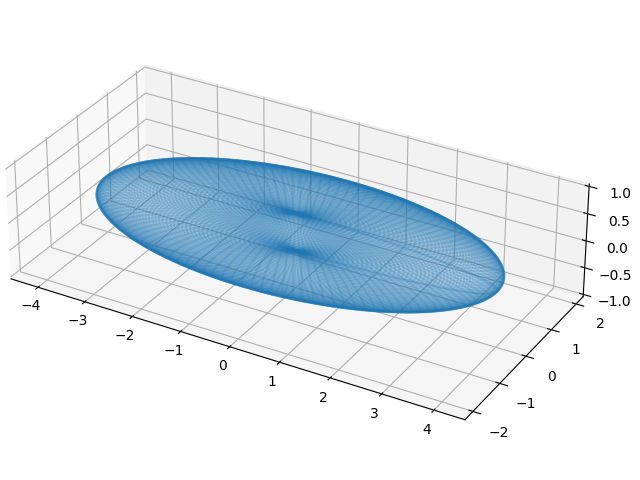

In [11]:
plt.close('all')
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Angle of the projection in the xy-plane
phi = np.linspace(0, 2*np.pi, 256).reshape(256, 1)
# Angle from the polar axis, i.e. the polar angle
theta = np.linspace(0, np.pi, 256).reshape(-1, 256)
# Ellipsoid formulas in spherical coordinate system
x = 4*np.sin(theta)*np.cos(phi)
y = 2*np.sin(theta)*np.sin(phi)

# The parametrized function to be plotted (half of the smallest ellipsoid axis i.e. the magnitude of sigma3)
def z(r_z, theta, phi):
    return r_z*np.cos(theta)

# Define initial parameter
r_z_init = 1

# Draw ellipsoid
ellip = ax.plot_wireframe(x, y, z(r_z_init, theta, phi), rstride = 2, cstride = 2, alpha = 0.2)         
ax.set_box_aspect((4, 2, 1))
# Adjust formatting
fig.subplots_adjust(left = 0, right = .9, bottom = -1.5, top = 2.5)
ticks_y = np.arange(-2.0, 3.0, 1.0)
ticks_z = np.arange(-1.0, 1.5, 0.5)
ax.set_yticks(ticks_y)
ax.set_zticks(ticks_z)

num_frames = 20

def animate(i):
    # During the last frame, snap to the true solution
    if i == num_frames - 1: sig_3 = 1
    # Otherwise, iterate through possible slopes
    else: sig_3 = 1 - i/20
    ax.collections.clear()
    ellip = ax.plot_wireframe(x, y, z(sig_3, theta, phi), rstride = 2, cstride = 2, alpha = 0.2) 
    ax.set_yticks(ticks_y)
    ax.set_zticks(ticks_z)
    fig.canvas.draw_idle()

frames = np.arange(0, num_frames - 1)
# Pause the animation at the end before looping
frames = np.append(frames, (num_frames - 2)*np.ones(5, dtype = np.int64))
frames = np.append(frames, [num_frames - 1])

# Create an animated GIF of this plot
ani = FuncAnimation(
    fig, animate, interval = 20, frames = frames, blit = True, save_count = 50, repeat = True)

# Save the GIF (optional)
# ani.save('ellipsoid-animation.gif', writer='imagemagick', fps = 20)
plt.show()